In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/road risk assessment/"
road_sctn_id = pd.read_excel(path+'road_sctn_id_list_test.xlsx', header=0)
a3Link = pd.read_excel(path+'A3Link_test.xlsx', header=0)
c1Node = pd.read_excel(path+'C1Node_test.xlsx', header=0)
center = pd.read_excel(path+'Center_test.xlsx', header=0)

In [ ]:
df_road_sctn = road_sctn_id
df_road_sctn = pd.merge(df_road_sctn, a3Link,  how='left', left_on = ['road_sctn_id'], right_on = ['HDUFID'])
df_road_sctn = df_road_sctn[["lane_sctn_id", "road_sctn_id", "LINKID", "FROMNODE", "TONODE", "LENGTH", "LANE"]]

In [ ]:
df_road_sctn = pd.merge(df_road_sctn, c1Node,  how='left', left_on = ['FROMNODE'], right_on = ['NODEID'])
df_road_sctn = df_road_sctn[["lane_sctn_id", "road_sctn_id", "LINKID", "FROMNODE", "TONODE", "LENGTH", "LANE", "xcoord", "ycoord", "zcoord"]]
df_road_sctn.rename(columns={"xcoord": "start_x", "ycoord": "start_y", "zcoord": "start_z"},inplace=True,)

In [ ]:
df_road_sctn = pd.merge(df_road_sctn, c1Node,  how='left', left_on = ['TONODE'], right_on = ['NODEID'])
df_road_sctn = df_road_sctn[["lane_sctn_id", "road_sctn_id", "LINKID", "FROMNODE", "TONODE", "LENGTH", "LANE", "start_x", "start_y", "start_z", "xcoord", "ycoord", "zcoord"]]
df_road_sctn.rename(columns={"xcoord": "end_x", "ycoord": "end_y", "zcoord": "end_z"},inplace=True,)

In [ ]:
df_road_sctn = pd.merge(df_road_sctn, center,  how='left', left_on = ['road_sctn_id'], right_on = ['HDUFID'])
df_road_sctn.rename(columns={"xcoord": "center_x", "ycoord": "center_y", "LENGTH_x": "LENGTH",  "LANE_x": "LANE"},inplace=True,)
df_road_sctn = df_road_sctn[["lane_sctn_id", "road_sctn_id", "LENGTH", "LANE", "start_x", "start_y", "start_z", "end_x", "end_y", "end_z", "center_x", "center_y"]]

In [ ]:
# Elevation Derivation
df_road_sctn['cross_road'] = ""
for i in range(len(df_road_sctn)):
  if df_road_sctn['road_sctn_id'][i][0] == 'A':
    df_road_sctn['cross_road'][i] = 0
  else:
    df_road_sctn['cross_road'][i] = 1

<ipython-input-10-3eeab299b66b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_road_sctn['cross_road'][i] = 1


In [ ]:
# Elevation Derivation
df_road_sctn['elevation'] = ""
for i in range(len(df_road_sctn)):
   df_road_sctn['elevation'][i] = df_road_sctn['end_z'][i] - df_road_sctn['start_z'][i]

<ipython-input-11-64411d9deb57>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_road_sctn['elevation'][i] = df_road_sctn['end_x'][i] - df_road_sctn['start_x'][i]


In [ ]:
### if all road sctns are in order
#df_road_sctn['elevation_delta'] = ''
#for i in range(len(df_road_sctn)):
#  if i == 0:
#    df_road_sctn['elevation_delta'][i] = 0 ## have to fill in manually
#  else:
#    df_road_sctn['elevation_delta'][i] = df_road_sctn['elevation'][i+1] - df_road_sctn['elevation'][i-1]

In [ ]:
np.arccos(df_road_sctn['start_x'][0])

<ipython-input-52-f887f759eef0>:1: RuntimeWarning: invalid value encountered in arccos
  np.arccos(df_road_sctn['start_x'][0])


nan

In [ ]:
np.arccos(df_road_sctn['start_x'][0])

<ipython-input-54-f887f759eef0>:1: RuntimeWarning: invalid value encountered in arccos
  np.arccos(df_road_sctn['start_x'][0])


nan

In [ ]:
np.radians(df_road_sctn['start_x'][0])

2.2183071927959648

In [ ]:
# Curve Radius Derivation
df_road_sctn['curve'] = ""
for i in range(len(df_road_sctn)):
  d1 = np.arccos(np.sin(np.radians(df_road_sctn['start_y'][i]))*np.sin(np.radians(df_road_sctn['center_y'][i]))+np.cos(np.radians(df_road_sctn['start_y'][i]))*np.cos(np.radians(df_road_sctn['center_y'][i]))*np.cos(np.radians(df_road_sctn['center_x'][i])-np.radians(df_road_sctn['start_x'][i])))*6371000
  d2 = np.arccos(np.sin(np.radians(df_road_sctn['center_y'][i]))*np.sin(np.radians(df_road_sctn['end_y'][i]))+np.cos(np.radians(df_road_sctn['center_y'][i]))*np.cos(np.radians(df_road_sctn['end_y'][i]))*np.cos(np.radians(df_road_sctn['end_x'][i])-np.radians(df_road_sctn['center_x'][i])))*6371000
  d3 = np.arccos(np.sin(np.radians(df_road_sctn['start_y'][i]))*np.sin(np.radians(df_road_sctn['end_y'][i]))+np.cos(np.radians(df_road_sctn['start_y'][i]))*np.cos(np.radians(df_road_sctn['end_y'][i]))*np.cos(np.radians(df_road_sctn['end_x'][i])-np.radians(df_road_sctn['start_x'][i])))*6371000
  df_road_sctn['curve'][i] = (d1*d2*d3)/np.sqrt((d1+d2+d3)*(-d1+d2+d3)*(d1-d2+d3)*(d1+d2-d3))

<ipython-input-12-9074ebff572b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_road_sctn['curve'][i] = (d1*d2*d3)/np.sqrt((d1+d2+d3)*(-d1+d2+d3)*(d1-d2+d3)*(d1+d2-d3))


In [ ]:
### if all road sctns are in order
#df_road_sctn['curve_delta'] = ''
#for i in range(len(df_road_sctn)):
#  if i == 0:
#    df_road_sctn['curve_delta'][i] = 0 ## have to fill in manually
#  else:
#    df_road_sctn['curve_delta'][i] = df_road_sctn['curve'][i+1] - df_road_sctn['curve'][i-1]

### Final Preprocessing must be proceeded
### Finally, We need to add 'adb' from autonomous vehicle driving analysis model (risky driving behavior)

# Model Application

In [ ]:
# load dataset
path = ""
df_all = pd.read_csv('', header=0)
df_part = pd.read_csv('', header=0)

In [ ]:
df_part.head()

road_sctn_id_detail  lane_no  cross_road  length  elevation  \
0       A3LI194G000418        2           0  60.420  -4.290649   
1  B2SL194G000045_down        1           1  32.363   0.569279   
2       A3LI194G000385        6           0  70.390   2.030041   
3       A3LI194G000395        7           0  26.080   0.498386   
4       A3LI194G000404        6           0   4.780   0.079000   

   elevation_delta       curve  curve_delta  adb  
0         2.741782  591.474361   -72.946977    0  
1         6.320690   15.556981   372.673527    0  
2        -0.070893  964.147889   323.400813    1  
3        -1.951041  338.957794  -961.589866    0  
4        -0.193896    2.558023   110.392700    0

In [ ]:
x_part = df_part.loc[:, 'lane_no':'curve_delta'].values
x_all = df_all.loc[:, 'lane_no':'curve_delta'].values

In [ ]:
y_part = df_part["adb"].values
y_all = df_all["adb"].values

In [ ]:
x_part = df_part.loc[:, 'lane_no':'curve_delta']
x_all = df_all.loc[:, 'lane_no':'curve_delta']

In [ ]:
y_part = df_part["adb"]
y_all = df_all["adb"]

In [ ]:
# Model Construction
dpart = xgb.DMatrix(x_part, label=y_part)
dall = xgb.DMatrix(x_all, label=y_all)

In [ ]:
# Model Parameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'logloss'  # Using binary logloss evaluation metric
}

num_round = 100
bst_part = xgb.train(params, dpart, num_round)

In [ ]:
num_round = 100
bst_all = xgb.train(params, dall, num_round)

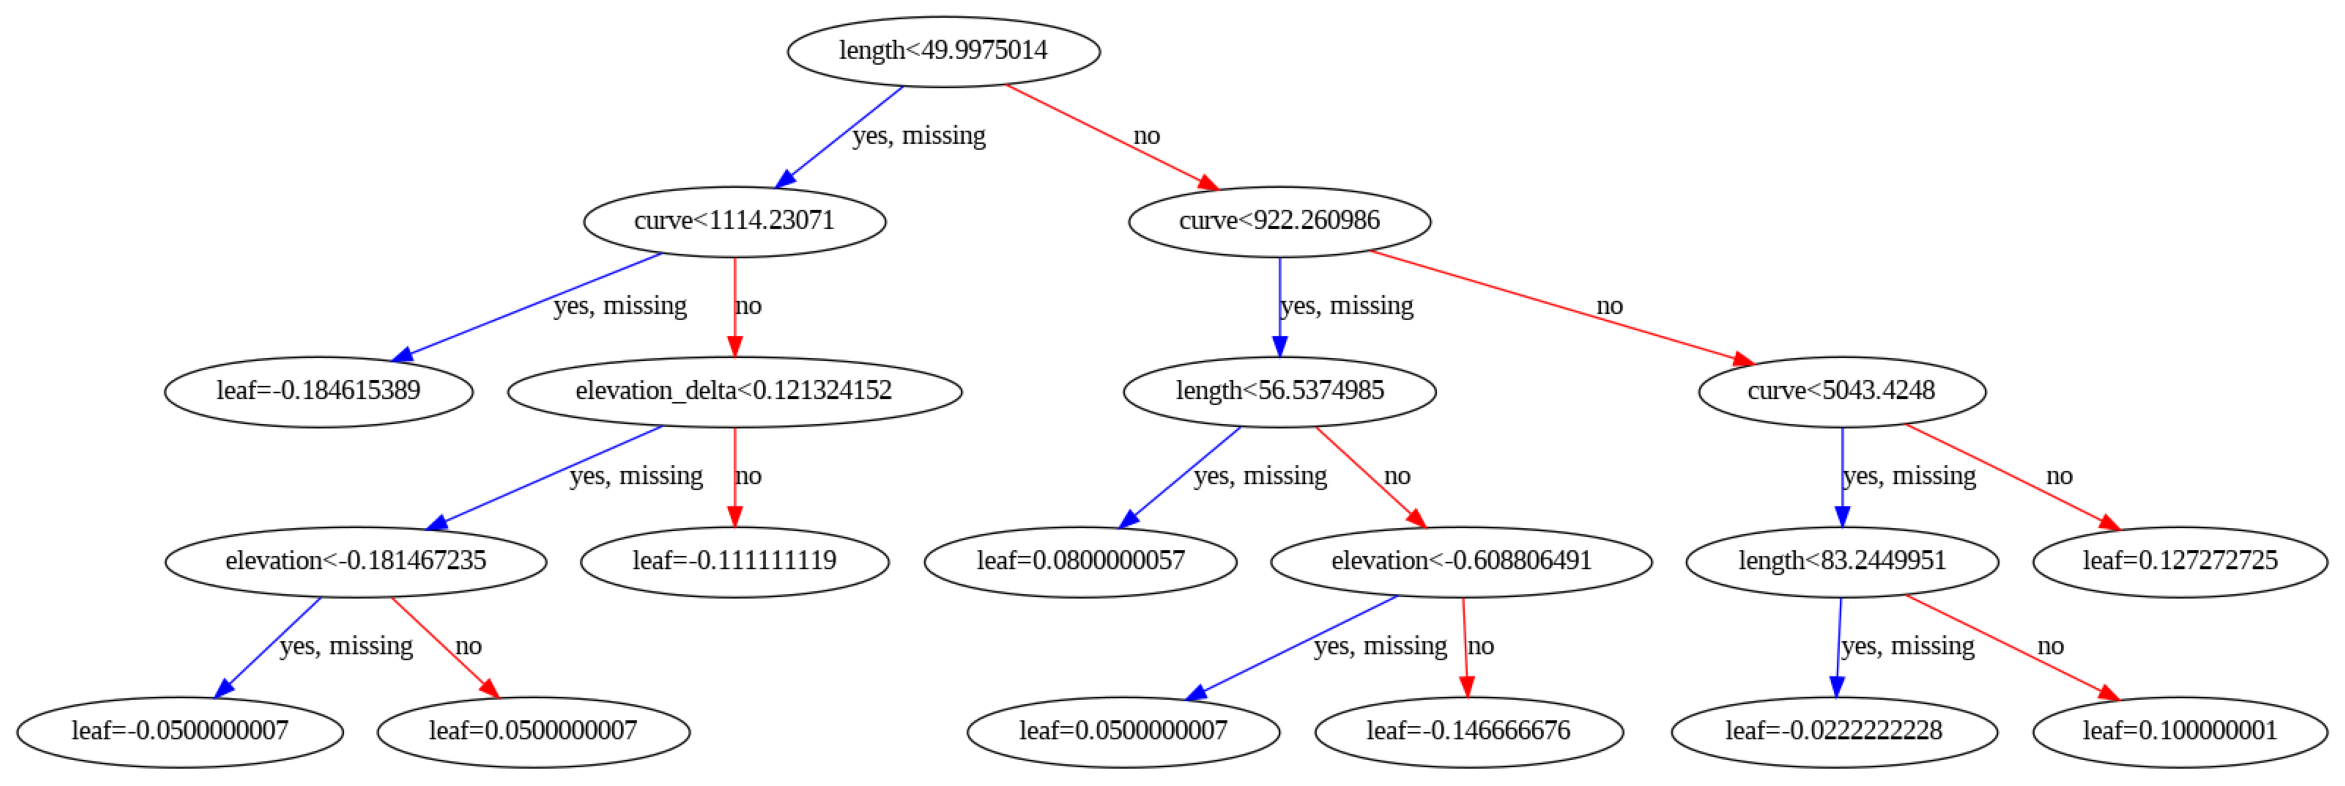

In [ ]:
# Model Visualization
plt.rcParams["figure.figsize"] = (15,10)
#plt.figure(figsize=(30,10))
xgb.plot_tree(bst_all, num_trees=0)

plt.show()

# Feature Importance Visualization

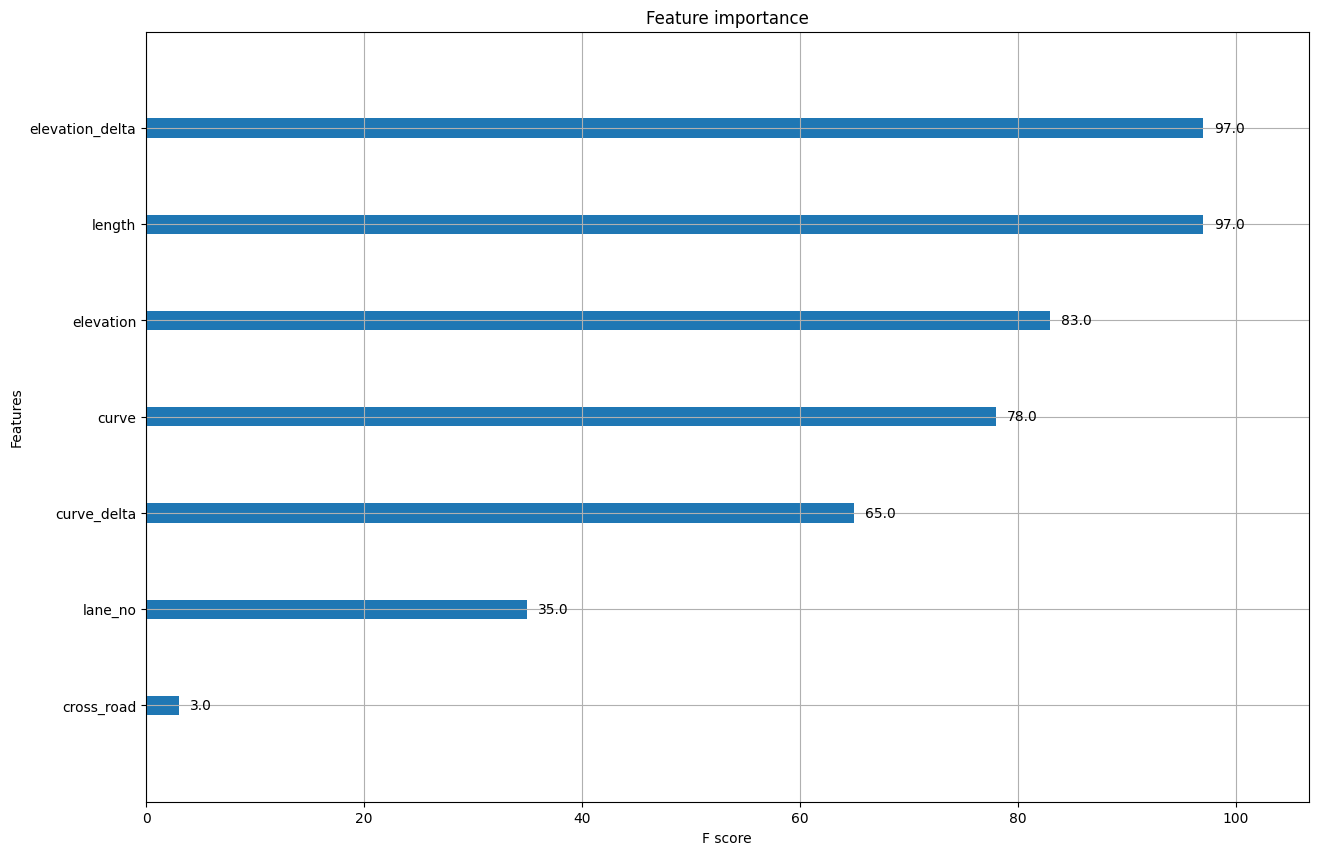

In [ ]:
xgb.plot_importance(bst_all)
plt.show()